In [235]:
import numpy as np
import matplotlib.pyplot as plt
from polar_codes.polar_code import PolarCode
from polar_codes.channels.bpsk_awgn_channel import BpskAwgnChannel

In [236]:
ARIKAN_KERNEL = np.array([[1,0],
                         [1,1]], np.int8)

In [237]:
def kernel(deg):    
    """Generator matrix of the polar code"""
    result = ARIKAN_KERNEL
    for i in range(deg-1):
        result = np.kron(result, ARIKAN_KERNEL)
    return result

In [238]:
def encoding(data_en, G_matrix):
    """Encoding function"""
    return np.dot(data_en, G_matrix) % 2

In [239]:
def ber_calculation(sent_mes, received_mes):
    num_errors = 0
    for i in range(len(sent_mes)):
        if sent_mes[i] != received_mes[i]:
            num_errors += 1
    return num_errors / len(sent_mes)

In [240]:
def bpsk_modulation(signal):
    modulated_signal = []
    for i in signal:
        modulated_signal.append(np.where(i > 0, 1, -1))
    return modulated_signal

def bpsk_demodulation(signal):
    demodulated_signal = []
    for i in signal:
        demodulated_signal.append(np.where(i > 0, 1, 0))
    return demodulated_signal

In [241]:
def awgn_generator(snr, signal_len):
    return np.random.randn(signal_len)*(1 / np.sqrt(2 * 10 ** (snr / 10)))

In [242]:
ssc_decoder_2_ber = []
ssc_decoder_4_ber = []
scl_decoder_2_ber = []
scl_decoder_4_ber = []

SNR_array = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [243]:
for n in [1, 2]:
    for snr in SNR_array:    
        K = 2**n
        
        channel = BpskAwgnChannel(snr)
        polar_code = PolarCode(n=n, K=K, construction_method='PW', channel=channel)
        u_message = np.asarray([0 if np.random.random_sample() > 0.5 else 1 for _ in range(0, K)], dtype='uint8')
        # encoding
        G = kernel(n)
        x_message = encoding(u_message, G)
        # modulation + transmission
        x_message_modulated = bpsk_modulation(x_message)
        transmission_in_channel = x_message_modulated + awgn_generator(snr, len(x_message_modulated))
        y_message = bpsk_demodulation(transmission_in_channel)
        
        # decoding
        if n == 1:
            ssc_u_dec_message = polar_code.decode(y_message, decoding_method='SSC')
            ssc_decoder_2_ber.append(ber_calculation(u_message, ssc_u_dec_message))
            scl_u_dec_message = polar_code.decode(y_message, decoding_method='SCL', list_size=32)
            scl_decoder_2_ber.append(ber_calculation(u_message, scl_u_dec_message))
        if n == 2:
            ssc_u_dec_message = polar_code.decode(y_message, decoding_method='SSC')
            ssc_decoder_4_ber.append(ber_calculation(u_message, ssc_u_dec_message))
            scl_u_dec_message = polar_code.decode(y_message, decoding_method='SCL', list_size=32)
            scl_decoder_4_ber.append(ber_calculation(u_message, scl_u_dec_message))

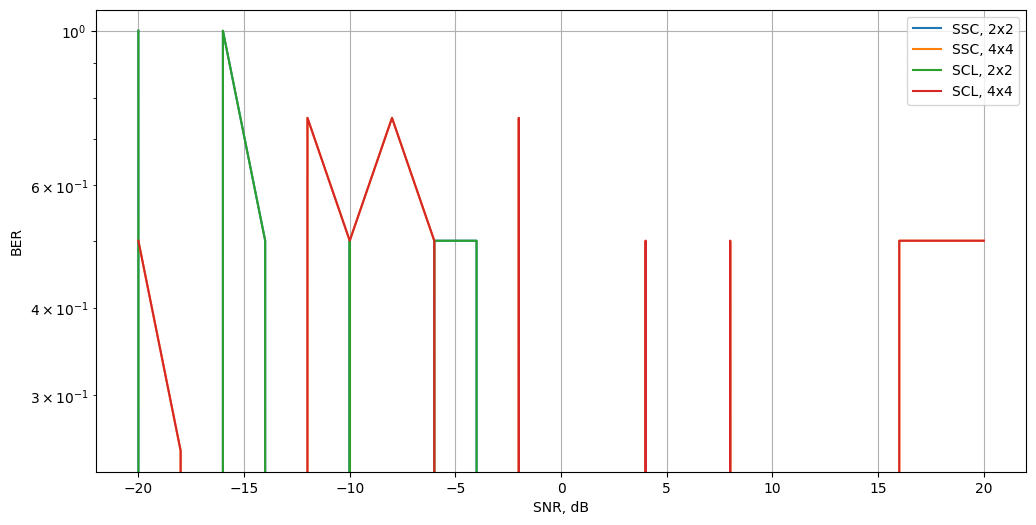

In [246]:
plt.figure(figsize=(12, 6))

plt.plot(SNR_array, ssc_decoder_2_ber, label = 'SSC, 2x2')
plt.plot(SNR_array, ssc_decoder_4_ber, label = 'SSC, 4x4')
plt.plot(SNR_array, scl_decoder_2_ber, label = 'SCL, 2x2')
plt.plot(SNR_array, scl_decoder_4_ber, label = 'SCL, 4x4')

plt.xlabel('SNR, dB')
plt.ylabel('BER')

plt.yscale('log')
plt.legend()
plt.grid()
plt.show()